<h2><사용 데이터셋></h2>

- (교통량 단독) [Metro Interstate Traffic Volume (Kaggle)](https://www.kaggle.com/datasets/pooriamst/metro-interstate-traffic-volume)

- (확장: 대기질 결합) [Air Quality Dataset (Kaggle)](https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set?utm_source=chatgpt.com)

<h2><프로젝트 목표></h2>

1. 교통량 패턴 분석

    - 시간대, 요일, 날씨, 휴일별 교통량 변화 규칙 찾기

   - 출퇴근 혼잡 시간대, 날씨 영향 등을 정량적으로 확인

2. 이상 상황 탐지

    - 평균 대비 현저히 높은 교통량 → “혼잡 알람” 발생

   - 관제센터에서 실시간 모니터링하듯 대시보드에 시각화


3. 확장 목표 (교통량 + 대기질 결합)

   - 교통량 데이터와 대기질 데이터를 시간축으로 맞춰 병합

   - “교통량이 많을수록 대기질 지표(PM2.5, NO₂ 등)가 악화되는가?” 검증

    - 교통·환경 복합 관제 시뮬레이션

#기본세팅

In [80]:
# 데이터 분석과 시각화를 위한 라이브러리 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.dates as mdates

In [2]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,807 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and dire

In [159]:
#  설치된 나눔고딕 파일 경로 (코랩 기본 위치)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

#  Matplotlib 폰트 매니저에 파일을 직접 등록
fm.fontManager.addfont(font_path)

#  파일에서 실제 폰트 '이름' 가져와 rcParams에 지정
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [4]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 파일 불러오기
df1 = pd.read_csv("/content/drive/MyDrive/분석/교통량_이상탐지/Metro_Interstate_Traffic_Volume.csv")
df2 = pd.read_csv("/content/drive/MyDrive/분석/교통량_이상탐지/AirQuality.csv", sep=";")

In [137]:
# 각각 traffic, air 변수에 저장
traffic = df1.copy()
air = df2.copy()

#0.전처리

In [138]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [139]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [140]:
# 날짜 컬럼을 datetime 타입으로 변환
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

# 필요 파생변수 추가 (요일, 시간)
traffic['weekday'] = traffic['date_time'].dt.dayofweek  # Monday=0, Sunday=6
traffic['hour'] = traffic['date_time'].dt.hour

In [141]:
traffic.shape

(48204, 11)

In [142]:
air.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [143]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [144]:
# 날짜+시간 합쳐서 datetime으로 변환
air['date_time'] = pd.to_datetime(
    air['Date'] + " " + air['Time'],
    format="%d/%m/%Y %H.%M.%S",
    errors="coerce"
)

In [145]:
# 사용하기 좋은 주요 컬럼만 선택
air = air[['date_time', 'CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH', 'AH']]

# 컬럼명 영어로 정리
air = air.rename(columns={
    'CO(GT)': 'CO',
    'NOx(GT)': 'NOx',
    'NO2(GT)': 'NO2',
    'T': 'temperature',
    'RH': 'humidity_rel',
    'AH': 'humidity_abs'
})

#1.교통량 데이터 EDA + 이상치 탐지

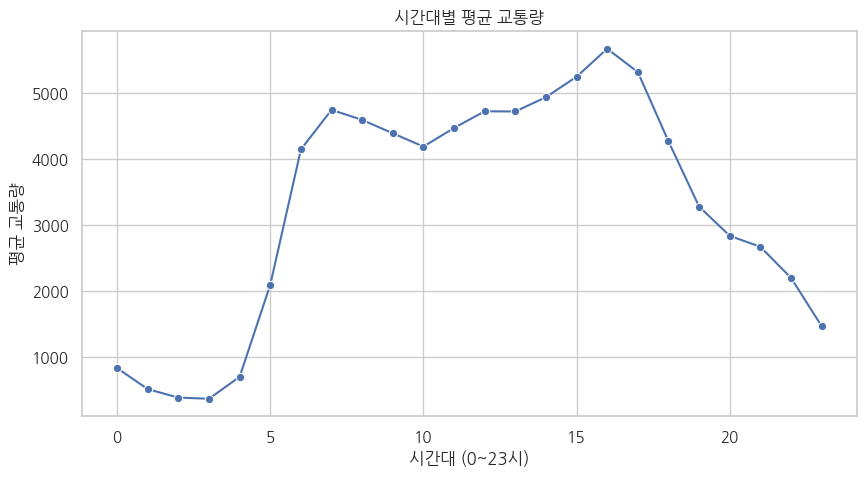

In [146]:
# 1. 시간대별 평균 교통량

# 시간대별 평균 교통량 계산
hourly = traffic.groupby('hour')['traffic_volume'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly.index, y=hourly.values, marker="o")
plt.title("시간대별 평균 교통량")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 교통량")
plt.grid(True)
plt.show()

새벽(0-4시)에는 교통량이 적고, 출근 시간(7-9시)과 퇴근 시간(16-18시)에 교통량이 급증하는 뚜렷한 패턴이 확인됨.

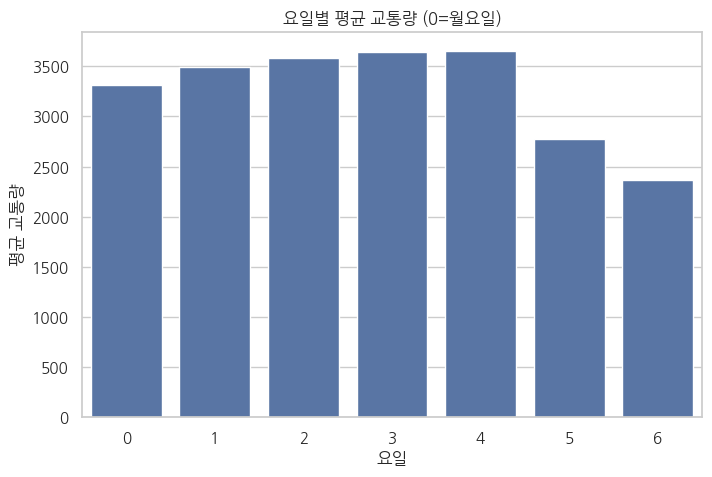

In [147]:
# 2. 요일별 평균 교통량

# 요일별 평균 교통량 (월=0, 일=6)
weekday = traffic.groupby('weekday')['traffic_volume'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=weekday.index, y=weekday.values)
plt.title("요일별 평균 교통량 (0=월요일)")
plt.xlabel("요일")
plt.ylabel("평균 교통량")
plt.show()

- 월~금요일은 비슷한 수준으로 높음 → 주중 출퇴근 수요 반영.

- 토·일요일은 교통량이 확연히 낮아짐 → 주말 혼잡이 상대적으로 적음을 의미.

In [148]:
# 3. 이상치 탐지 (혼잡 알람)

# 교통량 평균과 표준편차 계산
mean = traffic['traffic_volume'].mean()
std = traffic['traffic_volume'].std()

# 임계값 (평균 ± 2*표준편차)
upper = mean + 2*std
lower = mean - 2*std

# 이상치 여부 표시
traffic['anomaly'] = ((traffic['traffic_volume'] > upper) | (traffic['traffic_volume'] < lower))

print("이상치 비율:", traffic['anomaly'].mean())

이상치 비율: 8.298066550493735e-05


교통량 데이터 전체 중 이상치로 분류된 데이터의 비율 = 0.0083% 정도

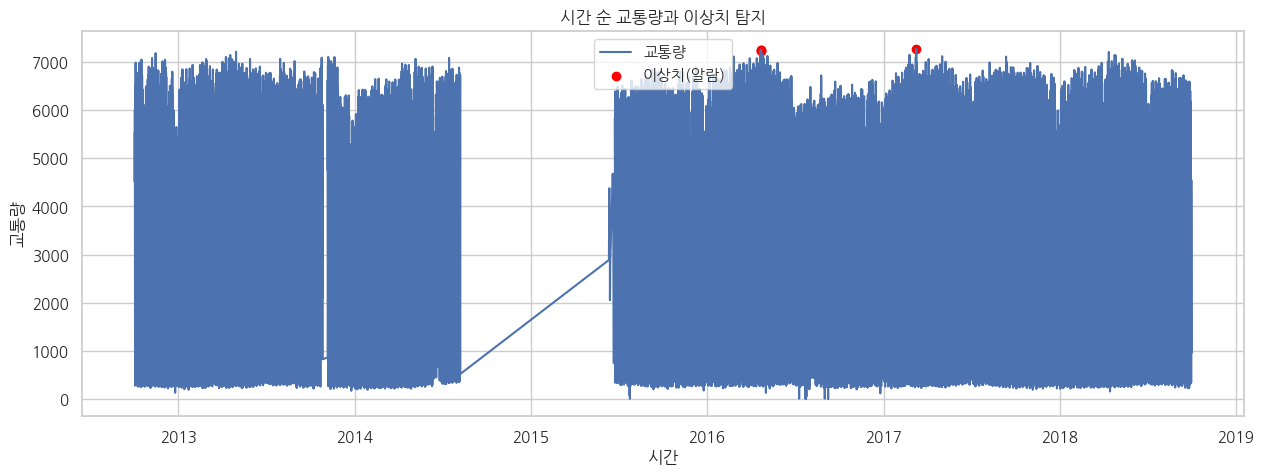

In [149]:
plt.figure(figsize=(15,5))
plt.plot(traffic['date_time'], traffic['traffic_volume'], label='교통량')
plt.scatter(
    traffic[traffic['anomaly']]['date_time'],
    traffic[traffic['anomaly']]['traffic_volume'],
    color='red', label='이상치(알람)'
)
plt.title("시간 순 교통량과 이상치 탐지")
plt.xlabel("시간")
plt.ylabel("교통량")
plt.legend()
plt.show()

* 2012~2018년 전체 기간 동안 평균 대비 크게 벗어난 값만 빨간 점으로 표시됨.

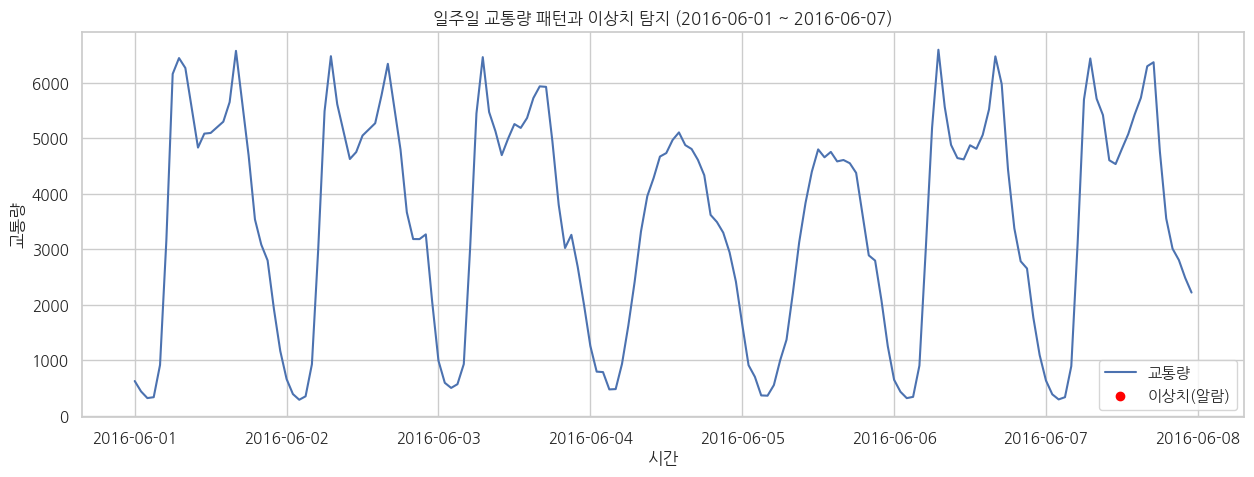

In [150]:
# 3-1. 특정 기간만 잘라서 보기

# 2016년 6월 1일 ~ 2016년 6월 7일 일주일 데이터만 선택
sample = traffic[(traffic['date_time'] >= "2016-06-01") & (traffic['date_time'] < "2016-06-08")]

plt.figure(figsize=(15,5))
plt.plot(sample['date_time'], sample['traffic_volume'], label='교통량')
plt.scatter(
    sample[sample['anomaly']]['date_time'],
    sample[sample['anomaly']]['traffic_volume'],
    color='red', label='이상치(알람)'
)
plt.title("일주일 교통량 패턴과 이상치 탐지 (2016-06-01 ~ 2016-06-07)")
plt.xlabel("시간")
plt.ylabel("교통량")
plt.legend()
plt.show()


하루 단위로 출근·퇴근 피크 → 야간 저점이 반복되는 주기적 패턴이 보임

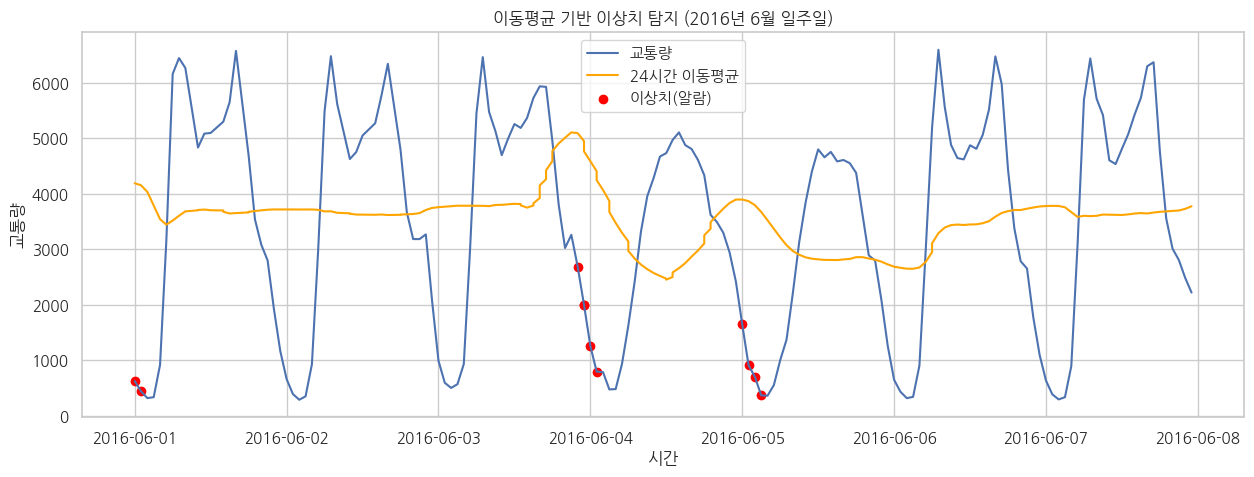

In [151]:
# 3-2. 이동평균 기반 탐지
# rolling()으로 24시간 이동평균과 이동표준편차 계산
traffic['rolling_mean'] = traffic['traffic_volume'].rolling(window=24).mean()
traffic['rolling_std'] = traffic['traffic_volume'].rolling(window=24).std()

# 이동평균 ± 2*이동표준편차를 벗어나면 이상치
traffic['anomaly_roll'] = (
    (traffic['traffic_volume'] > traffic['rolling_mean'] + 2*traffic['rolling_std']) |
    (traffic['traffic_volume'] < traffic['rolling_mean'] - 2*traffic['rolling_std'])
)

# 다시 2016년 6월 일주일만 잘라서 시각화
sample = traffic[(traffic['date_time'] >= "2016-06-01") & (traffic['date_time'] < "2016-06-08")]

plt.figure(figsize=(15,5))
plt.plot(sample['date_time'], sample['traffic_volume'], label='교통량')
plt.plot(sample['date_time'], sample['rolling_mean'], color='orange', label='24시간 이동평균')
plt.scatter(
    sample[sample['anomaly_roll']]['date_time'],
    sample[sample['anomaly_roll']]['traffic_volume'],
    color='red', label='이상치(알람)'
)
plt.title("이동평균 기반 이상치 탐지 (2016년 6월 일주일)")
plt.xlabel("시간")
plt.ylabel("교통량")
plt.legend()
plt.show()

24시간 이동평균선(주황색)과 비교했을 때, 평소 패턴에서 벗어난 구간에 빨간 알람이 표시됨.

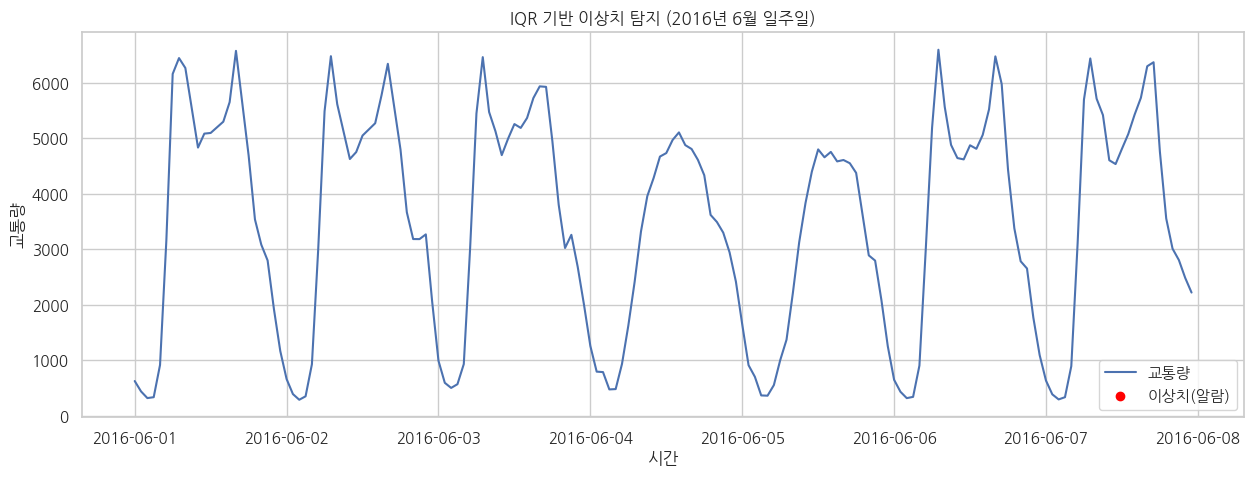

In [152]:
# 3-3. IQR(사분위 범위) 기반 탐지

# IQR 계산
Q1 = traffic['traffic_volume'].quantile(0.25)
Q3 = traffic['traffic_volume'].quantile(0.75)
IQR = Q3 - Q1

# IQR 범위를 벗어나면 이상치
traffic['anomaly_iqr'] = (
    (traffic['traffic_volume'] < Q1 - 1.5*IQR) |
    (traffic['traffic_volume'] > Q3 + 1.5*IQR)
)

# 다시 일주일 구간만 선택
sample = traffic[(traffic['date_time'] >= "2016-06-01") & (traffic['date_time'] < "2016-06-08")]

plt.figure(figsize=(15,5))
plt.plot(sample['date_time'], sample['traffic_volume'], label='교통량')
plt.scatter(
    sample[sample['anomaly_iqr']]['date_time'],
    sample[sample['anomaly_iqr']]['traffic_volume'],
    color='red', label='이상치(알람)'
)
plt.title("IQR 기반 이상치 탐지 (2016년 6월 일주일)")
plt.xlabel("시간")
plt.ylabel("교통량")
plt.legend()
plt.show()

#2.교통량 + 대기질 결합 분석

In [153]:
#1. 대기질 수치형 변환 (콤마→점, 숫자형 변환)


# 대기질 주요 변수
pollutants = ['CO', 'NOx', 'NO2', 'temperature', 'humidity_rel', 'humidity_abs']

# 소수점을 콤마(,)로 표기한 값이 있음 -> 콤마(,)로 표기된 값이 있으면 문자열로 읽힐 수 있으니 주의
for col in pollutants:
    air[col] = air[col].astype(str).str.replace(',', '.', regex=False)
    air[col] = pd.to_numeric(air[col], errors='coerce')

# 간단 확인
air[pollutants].dtypes

,0
CO,float64
NOx,float64
NO2,float64
temperature,float64
humidity_rel,float64
humidity_abs,float64


In [154]:
#2. 시간단위 리샘플링(평균) + 파생변수(요일/시간)

# 교통량: 숫자 컬럼만 선택해서 1시간 평균
traffic_num_cols = ['traffic_volume','temp','rain_1h','snow_1h','clouds_all']
traffic_hourly = (
    traffic.set_index('date_time')[traffic_num_cols]
           .resample('h')      # 'H' 경고 → 'h' 사용
           .mean()
).copy()
traffic_hourly['dow']  = traffic_hourly.index.dayofweek    # 0=월
traffic_hourly['hour'] = traffic_hourly.index.hour

# 대기질: 주요 컬럼만 1시간 평균
air_hourly = (
    air.set_index('date_time')[pollutants]
       .resample('h')
       .mean()
).copy()
air_hourly['dow']  = air_hourly.index.dayofweek
air_hourly['hour'] = air_hourly.index.hour

print("traffic_hourly:", traffic_hourly.shape, "| air_hourly:", air_hourly.shape)

traffic_hourly: (52551, 7) | air_hourly: (9357, 8)


(dow: 주중/주말 패턴 / hour: 출퇴근 시간 패턴)

- 원본 데이터 분 단위/불규칙 -> 시계열 비교 어려움

- 1시간 단위 평균으로 바꿔서 교통량과 대기질을 맞춰줌 -> 같은 기준으로 분석 가능

In [155]:
#3. 대기질 “요일×시간대” 평균

air_profile = (
    air_hourly.groupby(['dow','hour'])[pollutants]
              .mean()
              .reset_index()
)
air_profile.head()

,dow,hour,CO,NOx,NO2,temperature,humidity_rel,humidity_abs
0,0,0,-30.925000,96.696429,45.964286,8.183929,45.173214,-6.158830
1,0,1,-31.125000,73.589286,35.678571,7.837500,46.082143,-6.161729
2,0,2,-31.428571,45.750000,20.000000,7.391071,47.582143,-6.163352
3,0,3,-45.912500,-178.107143,-180.107143,7.017857,48.385714,-6.170571
4,0,4,-114.062500,17.089286,5.839286,10.596429,54.019643,-2.579621


대기질 데이터는 교통량과 기간이 안 맞아서 -> 요일+시간별 평균 패턴으로 합성

In [132]:
#4. 분석 대상 날짜 선택 + 대기질 패턴 매핑(합성 시계열)

WEEK_START = "2016-06-01"
WEEK_END   = "2016-06-08"

traffic_week = traffic_hourly.loc[WEEK_START:WEEK_END].reset_index()
traffic_week = (
    traffic_week.merge(air_profile, on=['dow','hour'], how='left')
                .set_index('date_time')
)
print("합성 데이터 크기:", traffic_week.shape)
traffic_week.head(3)

합성 데이터 크기: (192, 13)


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,dow,hour,CO,NOx,NO2,temperature,humidity_rel,humidity_abs
date_time,,,,,,,,,,,,,
2016-06-01 00:00:00,628.0,289.50,0.0,0.0,20.0,2,0,-46.078182,100.036364,43.963636,-3.394545,32.805455,-17.200969
2016-06-01 01:00:00,441.0,289.48,0.0,0.0,20.0,2,1,-49.896364,80.090909,34.527273,0.052727,38.707273,-13.551718
2016-06-01 02:00:00,321.0,289.42,0.0,0.0,20.0,2,2,-50.120000,56.090909,24.581818,-0.329091,39.881818,-13.551725


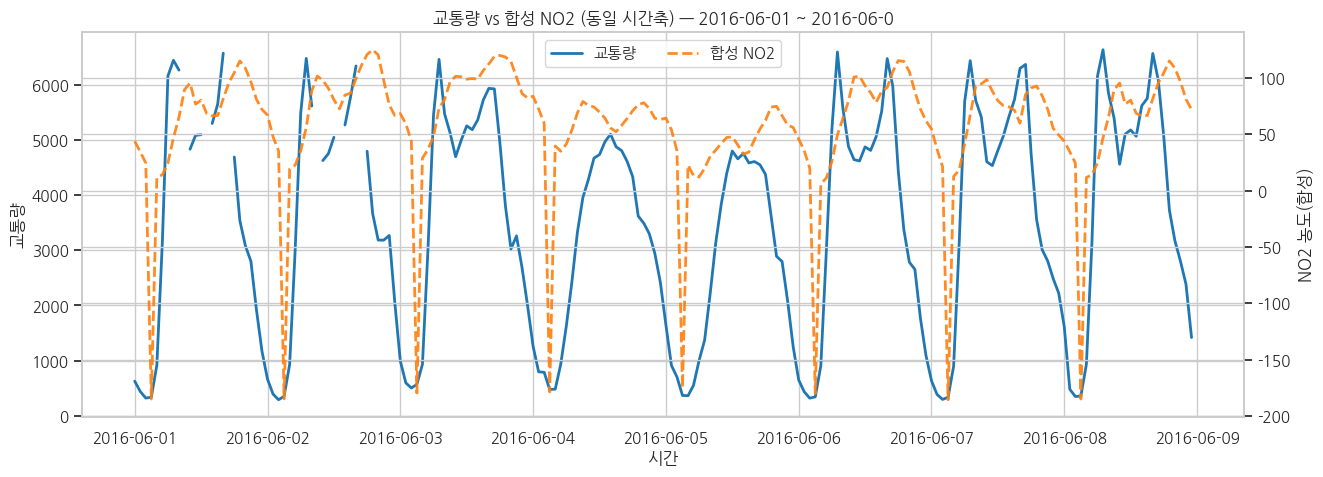

In [133]:
#5. 교통량 vs 합성 NO2 — 동일 시간축 라인차트

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()

# Seaborn 기본 팔레트에서 두 가지 색상 선택
c1, c2 = sns.color_palette("tab10", 2)

# 교통량 (실선, 파랑 계열)
ax1.plot(traffic_week.index, traffic_week['traffic_volume'],
         color=c1, linewidth=2, linestyle='-', label='교통량')

# NO2 (점선, 주황 계열)
ax2.plot(traffic_week.index, traffic_week['NO2'],
         color=c2, linewidth=2, linestyle='--', alpha=0.9, label='합성 NO2')

ax1.set_title(f"교통량 vs 합성 NO2 (동일 시간축) — {WEEK_START} ~ {WEEK_END[:-1]}")
ax1.set_xlabel("시간")
ax1.set_ylabel("교통량")
ax2.set_ylabel("NO2 농도(합성)")

# 범례 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper center", ncol=2)

plt.show()

In [157]:
# 분석용 결측치 처리 (둘 중 하나라도 NaN이면 제외)
week_clean = traffic_week[['traffic_volume', 'NO2']].dropna().copy()
print("결측치로 제외된 행 수:", len(traffic_week) - len(week_clean))

결측치로 제외된 행 수: 6


상관계수(교통량 vs 합성 NO2): 0.50


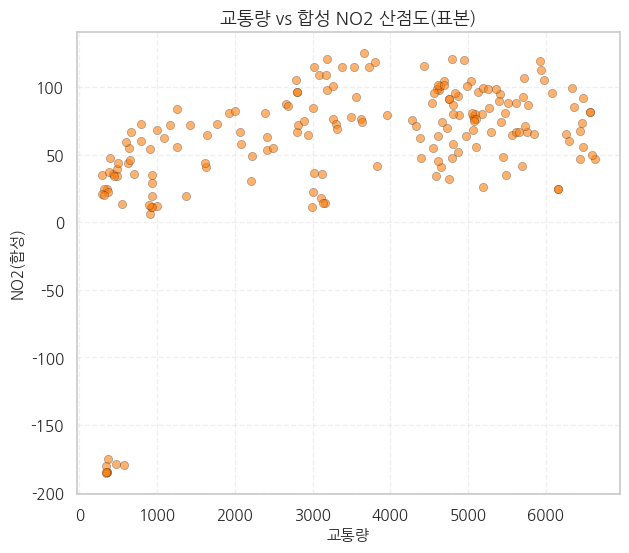

In [160]:
#6. 상관계수 & 산점도(표본)

corr_no2 = week_clean.corr(method='pearson').iloc[0,1]
print(f"상관계수(교통량 vs 합성 NO2): {corr_no2:.2f}")

# 산점도 — 표본 3000개까지만
sample_df = week_clean.sample(min(3000, len(week_clean)), random_state=42)

plt.figure(figsize=(7,6))
plt.scatter(sample_df['traffic_volume'], sample_df['NO2'],
            color=sns.color_palette("tab10")[1],  # 주황계열
            edgecolor="k", linewidth=0.3,
            s=35, alpha=0.6, marker="o")

plt.title("교통량 vs 합성 NO2 산점도(표본)", fontsize=13, weight="bold")
plt.xlabel("교통량", fontsize=11)
plt.ylabel("NO2(합성)", fontsize=11)
plt.grid(alpha=0.3, linestyle="--")
plt.show()


In [161]:
#7. 복합 알람(교통 혼잡 + 대기질 악화) 시뮬레이션


# 분위수 기반 임계값(상위 90%)
q_tv  = traffic_week['traffic_volume'].quantile(0.90)
q_no2 = traffic_week['NO2'].quantile(0.90)

traffic_week['alarm_traffic'] = traffic_week['traffic_volume'] > q_tv
traffic_week['alarm_air']     = traffic_week['NO2'] > q_no2
traffic_week['alarm_both']    = traffic_week['alarm_traffic'] & traffic_week['alarm_air']

print("혼잡 임계값(traffic_volume 90%):", int(q_tv))
print("대기질 임계값(NO2 90%):", round(q_no2, 2))
print("복합 알람 비율:", f"{traffic_week['alarm_both'].mean()*100:.2f}%")

혼잡 임계값(traffic_volume 90%): 5882
대기질 임계값(NO2 90%): 104.58
복합 알람 비율: 1.56%


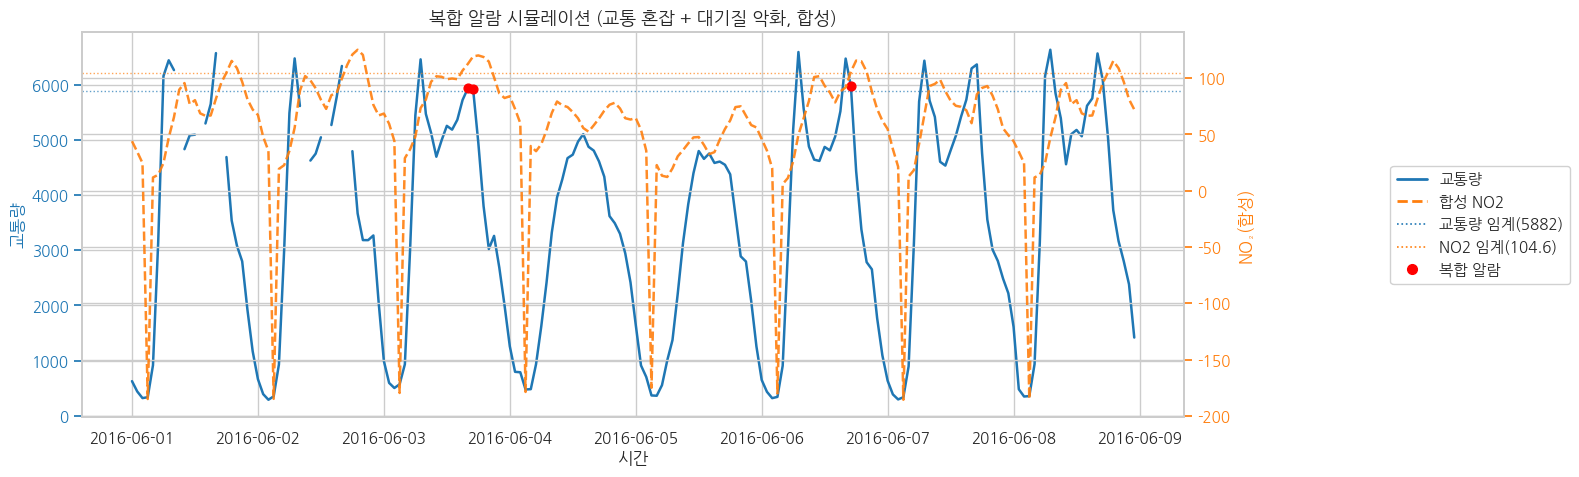

In [167]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()


c1, c2 = sns.color_palette("tab10", 2)

# 교통량
ax1.plot(traffic_week.index, traffic_week['traffic_volume'],
         color=c1, linewidth=1.8, label='교통량')

# NO2
ax2.plot(traffic_week.index, traffic_week['NO2'],
         color=c2, linewidth=1.8, linestyle="--", alpha=0.9, label='합성 NO2')

# 복합 알람 점
alarm_pts = traffic_week[traffic_week['alarm_both']]
ax1.scatter(alarm_pts.index, alarm_pts['traffic_volume'],
            color='red', s=40, marker="o", label='복합 알람', zorder=5)

# 임계선
ax1.axhline(q_tv,  color=c1, linestyle=":", linewidth=1, alpha=0.7)
ax2.axhline(q_no2, color=c2, linestyle=":", linewidth=1, alpha=0.7)

ax1.set_title("복합 알람 시뮬레이션 (교통 혼잡 + 대기질 악화, 합성)", fontsize=13, weight="bold")
ax1.set_xlabel("시간")
ax1.set_ylabel("교통량", color=c1); ax1.tick_params(axis='y', colors=c1)
ax2.set_ylabel("NO₂(합성)", color=c2); ax2.tick_params(axis='y', colors=c2)

# 범례
from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0],[0], color=c1, lw=2.0, ls='-',  label='교통량'),
    Line2D([0],[0], color=c2, lw=2.0, ls='--', label='합성 NO2'),
    Line2D([0],[0], color=c1, lw=1.2, ls=':',  label=f'교통량 임계({int(q_tv)})'),
    Line2D([0],[0], color=c2, lw=1.2, ls=':',  label=f'NO2 임계({q_no2:.1f})'),
    Line2D([0],[0], marker='o', ms=7, lw=0, markerfacecolor='red',
           markeredgecolor='red', label='복합 알람'),
]

# 오른쪽 여백 넉넉히
ax1.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc='center left', bbox_to_anchor=(1.18, 0.5),
           frameon=True, framealpha=0.9)
plt.subplots_adjust(right=0.86)   # <- 여백 키움
plt.show()


교통량 임계선: 5882 / NO₂ 임계선: 104.6 [두 조건을 동시에 넘는 경우 → 복합 알람(빨간 점)]

교통량과 NO₂는 양의 상관관계(0.50) 존재 → 교통이 많아지면 대체로 NO₂도 증가.
하지만 NO₂는 날씨 등 다른 요인의 영향도 커서, 단순히 교통량만으로 설명하기에는 부족.

임계값 기반 복합 알람 분석을 통해, 위험 구간(교통 혼잡 + 대기질 악화) 을 탐지할 수 있음 → 도시 교통 정책, 대기질 관리에 활용 가능.